In [1]:
import pandas as pd
import numpy as np
import gudhi as gd
from gudhi.weighted_rips_complex import WeightedRipsComplex
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from gudhi.point_cloud.dtm import DistanceToMeasure
from gudhi.hera import wasserstein_distance
from gudhi.representations import PersistenceImage, BettiCurve
from sklearn.decomposition import PCA
import umap
from gudhi.representations.metrics import WassersteinDistance
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import MDS
import os
from scipy import stats
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from scipy import signal
from scipy.stats import levy_stable
from symulacja_py import impsim
#%matplotlib widget

/home/niklas/anaconda3/envs/MachineSignalProcessing/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def create_signal(alpha, impulse_amplitude):
    fs = 25000
    fmod = 30
    f_center = 5000
    bandwidth = 1500
    shift = 0

    amp_imp = impulse_amplitude
    alfa = alpha
    skala = 0.5

    varsize = 2*fs
    tt_ts = np.linspace(1/fs,varsize/fs,varsize)
    #szum = np.random.normal(0,skala,varsize) #szum Gaussowski
    szum = levy_stable.rvs(alfa,0,0,skala,varsize)  #szum alfa-stabilny

    signal_l = 9*impsim(fs,varsize,fmod,amp_imp,f_center,bandwidth,shift)+szum
    return signal_l

def rips_ph1(point_clouds, weighted = True):
    pds = []
    
    for pc in point_clouds:
        if weighted:
            dist = cdist(pc,pc)
            dtm = DistanceToMeasure(5, dim = 10, q=2, metric="precomputed")
            r = dtm.fit_transform(dist)
            ac = WeightedRipsComplex(distance_matrix=dist,weights = 1/r)
        else:
            ac = gd.RipsComplex(points=pc)

        st = ac.create_simplex_tree(max_dimension = 2)
        st.compute_persistence()
        pd = st.persistence_intervals_in_dimension(1)
        pds.append(pd)
    return pds

def swe_pointclouds_from_noise(mc_iterations, alpha, amplitude, dim, delay, skip, normalize = True):
    data = []
    for i in range(mc_iterations):
        data.append(create_signal(alpha, amplitude))
    #dim * delay should roughly equal len(time_series)/numer_of_periods
    dim = 3*833#417# half period
    delay = len(data[0])//dim
    #print("delay", delay)
    skip = 1#200#0#100
    #print(dim*delay)
    #print(len(data[0])/24)

    #print("===============computing SWE====================")
    tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
    point_clouds = tde.transform(data)

    if (normalize):
        for i in range(0,len(point_clouds)):
            point_clouds[i] = point_clouds[i]-np.mean(point_clouds[i],1)[:, None]
            point_clouds[i] = point_clouds[i]/np.sqrt(np.sum(point_clouds[i]**2, 1))[:, None]

    #print(np.array(point_clouds).shape)
    #print(len(point_clouds[0]))
    return point_clouds

In [51]:
#generate data under null, i.e. only noise
alphas = np.linspace(1.1,2,19)

amplitude = 0
mc_iterations = 5000
avg_bcs = []
acc_threshs = np.zeros_like(alphas, dtype = float)

dim = 3*833#417# half period
delay = 50000//dim
#print("delay", delay)
skip = 1#200#0#100
#print(dim*delay)
#print(len(data[0])/24)

#start = min([np.min(d) for d in pds])-0.005
#end = max([np.max(d) for d in pds])+0.005
#print(start,end)
start = 2.989
end = 3.16
grid = np.linspace(start,end,10000)


def compute_avg_bc(k):
    alpha = alphas[k]
    print("***************alpha=",alpha,"******************")
    #print("=============generating data====================")
    point_clouds = swe_pointclouds_from_noise(mc_iterations, alpha, amplitude, dim, delay, skip)  
    #print("=============computing Rips PH==================")
    pds = rips_ph1(point_clouds)

    #print("=============computing betti curves==============")

    
    bc = BettiCurve(predefined_grid=grid)
    betti_curves = bc.fit_transform(pds)
    avg_bc = np.mean(betti_curves, axis=0)
    return avg_bc

def compute_acc_thresh(k, metric ="l1"):
    alpha = alphas[k]
    avg_bc = avg_bcs[k]
    point_clouds = swe_pointclouds_from_noise(mc_iterations, alpha, amplitude, dim, delay, skip) 
    #print("=============computing Rips PH==================")
    pds = rips_ph1(point_clouds)

    #print("=============computing betti curves==============")
    bc = BettiCurve(predefined_grid=grid)
    betti_curves = bc.fit_transform(pds)
    if metric == "l1":
        acc_thresh = np.quantile(cdist([avg_bc],betti_curves, "minkowski", p=1)[0],0.95)
    elif metric == "max":
        acc_thresh = np.quantile(cdist([avg_bc],betti_curves, "chebyshev")[0],0.95)
    #acc_threshs[k] = acc_thresh
    return (k, acc_thresh)




In [52]:
from joblib import Parallel, delayed
avg_bcs = Parallel(n_jobs=4)(delayed(compute_avg_bc)(k) for k in range(0,len(alphas)) )
results = Parallel(n_jobs=4)(delayed(compute_acc_thresh)(k, "max") for k in range(0,len(alphas)) )


***************alpha= 1.1 ******************
***************alpha= 1.1500000000000001 ******************
***************alpha= 1.25 ******************
***************alpha= 1.2000000000000002 ******************


exception calling callback for <Future at 0x7ff5ac440520 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/home/niklas/anaconda3/envs/MachineSignalProcessing/lib/python3.10/site-packages/joblib/externals/loky/_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "/home/niklas/anaconda3/envs/MachineSignalProcessing/lib/python3.10/site-packages/joblib/parallel.py", line 385, in __call__
    self.parallel.dispatch_next()
  File "/home/niklas/anaconda3/envs/MachineSignalProcessing/lib/python3.10/site-packages/joblib/parallel.py", line 834, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/niklas/anaconda3/envs/MachineSignalProcessing/lib/python3.10/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/niklas/anaconda3/envs/MachineSignalProcessing/lib/python3.10/site-packages/joblib/parallel.py", line 819, in _dispatch
    job = self._backend.app

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

In [39]:
print("result",results)

for i in range(0,len(results)):
    acc_threshs[i] = results[i][1]
print("threshs",acc_threshs)

result [(0, 626.706899999999), (1, 711.7804999999978), (2, 792.1389999999963), (3, 866.3667999999951), (4, 952.9706999999953), (5, 1030.0754999999933), (6, 1103.2730999999926), (7, 1181.363199999996), (8, 1221.4762999999962), (9, 1253.9147999999973), (10, 1297.5730999999948), (11, 1307.7389999999968), (12, 1277.838899999993), (13, 1256.9163999999932), (14, 1206.4138999999927), (15, 1164.532899999993), (16, 1099.0923999999945), (17, 1082.6811999999977), (18, 1095.2128999999995)]
threshs [ 626.7069  711.7805  792.139   866.3668  952.9707 1030.0755 1103.2731
 1181.3632 1221.4763 1253.9148 1297.5731 1307.739  1277.8389 1256.9164
 1206.4139 1164.5329 1099.0924 1082.6812 1095.2129]


In [15]:
amplitudes = np.linspace(0,2,3)
test_powers_alpha = np.zeros((len(alphas),len(amplitudes)), dtype=float)


In [40]:
print(len(acc_threshs))
avg_bcs[0]

19


array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e-03, 1.0000e-03, 1.0000e-03, 1.0000e-03,
       1.0000e-03, 1.0000e-03, 1.0000e-03, 3.0000e-03, 3.0000e-03,
       4.0000e-03, 4.0000e-03, 6.0000e-03, 8.0000e-03, 1.1000e-02,
       1.3000e-02, 1.7000e-02, 2.6000e-02, 3.3000e-02, 4.3000e-02,
       7.2000e-02, 1.0800e-01, 1.9600e-01, 3.3800e-01, 5.3000e-01,
       8.0300e-01, 1.2050e+00, 1.6340e+00, 2.3170e+00, 3.0660e+00,
       3.8590e+00, 4.6870e+00, 5.5740e+00, 6.4580e+00, 7.4420e+00,
       8.2920e+00, 9.0890e+00, 9.8740e+00, 1.0518e+01, 1.1167e+01,
       1.1670e+01, 1.2171e+01, 1.2539e+01, 1.2745e+01, 1.2967e+01,
       1.2960e+01, 1.2952e+01, 1.2884e+01, 1.2836e+01, 1.2677e

In [31]:
def compute_test_power(k,j, metric = "l1"):
    a=amplitudes[j]
    alpha = alphas[k]
    print("******************",alpha,"*******************")
    print("=============generating data====================")
    point_clouds = swe_pointclouds_from_noise(mc_iterations,alpha,a,dim,delay,skip)
    
    print("=============computing Rips PH==================")
    pds = rips_ph1(point_clouds)
    print("computing bcs")
    bc = BettiCurve(predefined_grid=grid)
    betti_curves = bc.fit_transform(pds)
    print("computing dists")
    if metric == "l1":
        dists = cdist([avg_bcs[k]],betti_curves, "minkowski",p=1)[0]
    elif metric == "max":
        dists = cdist([avg_bcs[k]],betti_curves, "chebyshev")[0]
    print("computing test power")
    power = np.sum(dists>acc_threshs[k])/mc_iterations
    #test_powers_alpha[k][j] = power
    return power

In [41]:
from joblib import Parallel, delayed
#results = Parallel(n_jobs=4)(delayed(compute_test_power)(k, j) for k in range(0,len(alphas)) for j in range(0,len(amplitudes)))
#results = Parallel(n_jobs=4)(delayed(compute_test_power)(0, 0) for k in range(0,1) )
results = [compute_test_power(k, j) for k in range(0,len(alphas)) for j in range(0,len(amplitudes))]

****************** 1.1 *******************
=============generating data====================
=============computing Rips PH==================
computing bcs
computing dists
computing test power
****************** 1.1 *******************
=============generating data====================
=============computing Rips PH==================
computing bcs
computing dists
computing test power
****************** 1.1 *******************
=============generating data====================
=============computing Rips PH==================
computing bcs
computing dists
computing test power
****************** 1.1500000000000001 *******************
=============generating data====================
=============computing Rips PH==================
computing bcs
computing dists
computing test power
****************** 1.1500000000000001 *******************
=============generating data====================
=============computing Rips PH==================
computing bcs
computing dists
computing test power
**********

In [49]:
print(results)
test_powers_alpha = np.array(results).reshape((len(alphas),len(amplitudes)))


[0.05, 0.065, 0.078, 0.056, 0.06, 0.092, 0.051, 0.063, 0.118, 0.052, 0.065, 0.186, 0.055, 0.07, 0.344, 0.037, 0.079, 0.614, 0.056, 0.098, 0.895, 0.063, 0.13, 0.99, 0.045, 0.254, 0.999, 0.052, 0.492, 1.0, 0.035, 0.803, 1.0, 0.045, 0.985, 1.0, 0.056, 1.0, 1.0, 0.053, 1.0, 1.0, 0.054, 1.0, 1.0, 0.052, 1.0, 1.0, 0.045, 1.0, 1.0, 0.036, 1.0, 1.0, 0.042, 1.0, 1.0]


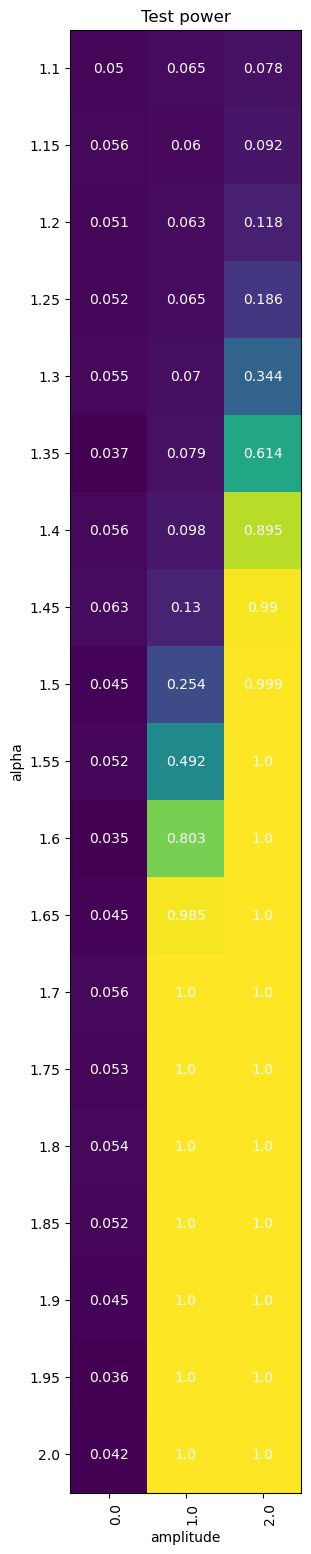

In [50]:
f,ax = plt.subplots(figsize = (21,19))
ax.imshow(test_powers_alpha)

ax.set_xticks(range(0,len(amplitudes)), labels=np.round(amplitudes,1))
ax.set_yticks(range(0,len(alphas)), labels = np.round(alphas,2))

ax.set_xlabel("amplitude")
ax.set_ylabel("alpha")

plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(alphas)):
    for j in range(len(amplitudes)):
        text = ax.text(j, i, test_powers_alpha[i][j],
                       ha="center", va="center", color="w")


#ax.scatter(np.linspace(0,20,21), 19*(-1.1+(1.7/((0.1*np.linspace(0,20,21))**(0.2)))), color="red")
plt.title("Test power")
#plt.savefig("GoF-test-powers.pdf")
plt.show()

In [ ]:
#np.savetxt("test_powers_alpha1.1-2_amplitude0-2.txt",np.array(test_powers_alpha))
#print(np.log(2/1.7)/np.log(0.5))
#print(np.log(1.5/1.7)/np.log(2))#
#np.sum(cdist([avg_bcs[k]],betti_curves, "chebyshev")[0]>acc_thresh)/2000
print(power)
print(test_powers)
#print((1.7**5)*(alphas**(-5)))

0.0375
[0]


In [23]:
np.array(results)

array([0.052, 0.051, 0.063, 0.051, 0.053, 0.073, 0.053, 0.066, 0.085,
       0.052, 0.053, 0.084, 0.046, 0.061, 0.118, 0.04 , 0.054, 0.132,
       0.057, 0.087, 0.57 , 0.05 , 0.094, 0.915, 0.074, 0.212, 0.999,
       0.06 , 0.342, 1.   , 0.05 , 0.564, 1.   , 0.054, 0.902, 1.   ,
       0.051, 0.998, 1.   , 0.045, 1.   , 1.   , 0.051, 1.   , 1.   ,
       0.056, 1.   , 1.   , 0.037, 1.   , 1.   , 0.055, 1.   , 1.   ,
       0.05 , 1.   , 1.   ])

In [ ]:
print(alphas)
print(amplitudes)

test_powers_alpha

[1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75
 1.8  1.85 1.9  1.95 2.  ]
[0. 1. 2.]


array([0., 0.])